In [869]:
from preprocessing import produce_data
from preprocessing_forecasting import produce_data_for
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from time import time
from pyod.utils.example import visualize
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
import seaborn as sns
import matplotlib.pyplot as plt
import mat73
import pyarrow.parquet as pq
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.models import load_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
import pickle

# DATA PREPARATION

In [7]:
data = produce_data()

In [228]:
#for each dataset create groups of 10 instances, downsample and then combine them into one dataset
downsampled_data = []

for dataset in data:
    groups_of_10 = [dataset[i:i+10] for i in range(0, len(dataset), 10)]
    modified_instances = []
    for group in groups_of_10:
        mean_values = np.mean(group, axis=0)
        new_instance = [group.index[-1]] + mean_values.tolist()
        modified_instances.append(new_instance)
    downsampled_data.extend(modified_instances)

In [290]:
df = pd.DataFrame(downsampled_data)
df.set_index(0, inplace=True)
df.columns = data[0].columns
df['Temp'] = 2 * (df['Temp'] - df['Temp'].min()) / (df['Temp'].max() - df['Temp'].min()) - 1
df['SoC'] = 2 * (df['SoC'] - df['SoC'].min()) / (df['SoC'].max() - df['SoC'].min()) - 1
df_sorted = df.sort_index()
df_sorted.head()

,Temp,SoC,"(Curr, Volt, 50, -10)","(DiffCurr, DiffVolt, 50, -10)","(Curr, Volt, 50, -5)","(DiffCurr, DiffVolt, 50, -5)","(Curr, Volt, 50, -2)","(DiffCurr, DiffVolt, 50, -2)","(Curr, Volt, 50, -1)","(DiffCurr, DiffVolt, 50, -1)",...,"(Curr, Volt, 200, 0)","(DiffCurr, DiffVolt, 200, 0)","(Curr, Volt, 200, 1)","(DiffCurr, DiffVolt, 200, 1)","(Curr, Volt, 200, 2)","(DiffCurr, DiffVolt, 200, 2)","(Curr, Volt, 200, 5)","(DiffCurr, DiffVolt, 200, 5)","(Curr, Volt, 200, 10)","(DiffCurr, DiffVolt, 200, 10)"
0,,,,,,,,,,,,,,,,,,,,,
1572642285087378,-0.076923,0.948084,-0.122062,-0.010807,-0.200995,-0.067672,-0.318070,0.044054,-0.399717,-0.221448,...,-0.756776,-0.327486,-0.690859,0.012473,-0.615226,0.184269,-0.511872,-0.021168,-0.431846,0.015825
1572642289941747,-0.076923,0.947960,-0.173296,-0.012525,-0.191346,-0.011968,-0.184174,0.039103,-0.197668,-0.042904,...,-0.626347,-0.023116,-0.620215,0.030899,-0.619273,0.026063,-0.622863,0.015741,-0.628318,-0.043031
1572642294796116,-0.076923,0.946848,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1572642299650485,-0.076923,0.946848,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1572642304504854,-0.076923,0.946848,-0.277498,-0.006703,-0.258624,0.015466,-0.215070,0.056555,-0.217469,-0.048649,...,-0.458429,0.004842,-0.458413,-0.000103,-0.458441,-0.005091,-0.456080,-0.020427,-0.473758,0.010043


In [291]:
split_index = int(0.8 * len(df_sorted))
X_train = df_sorted.iloc[:split_index, :]
X_test = df_sorted.iloc[split_index:, :]
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (54993, 56)
Testing set shape: (13749, 56)


# ECOD

- ECOD is based on computing the probability of observing a point at least as “extreme” as X_i. If the probability is extremely small,
then this suggests that X_i corresponds to a rare event (likely to be an outlier).
- ECOD first estimates the underlying distribution of the input data in a nonparametric fashion by computing the empirical cumulative distribution per dimension of the data. ECOD then uses these empirical
distributions to estimate tail probabilities per dimension for each data point. Finally, ECOD computes an outlier score of each data point
by aggregating estimated tail probabilities across dimensions.

In [292]:
from pyod.models.ecod import ECOD
clf = ECOD()
clf.fit(X_train)

ECOD(contamination=0.1, n_jobs=1)

In [293]:
# get predictions and outlier scores
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores on the train data

y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # predict raw outlier scores on test
y_test_proba = clf.predict_proba(X_test) # outlier probability

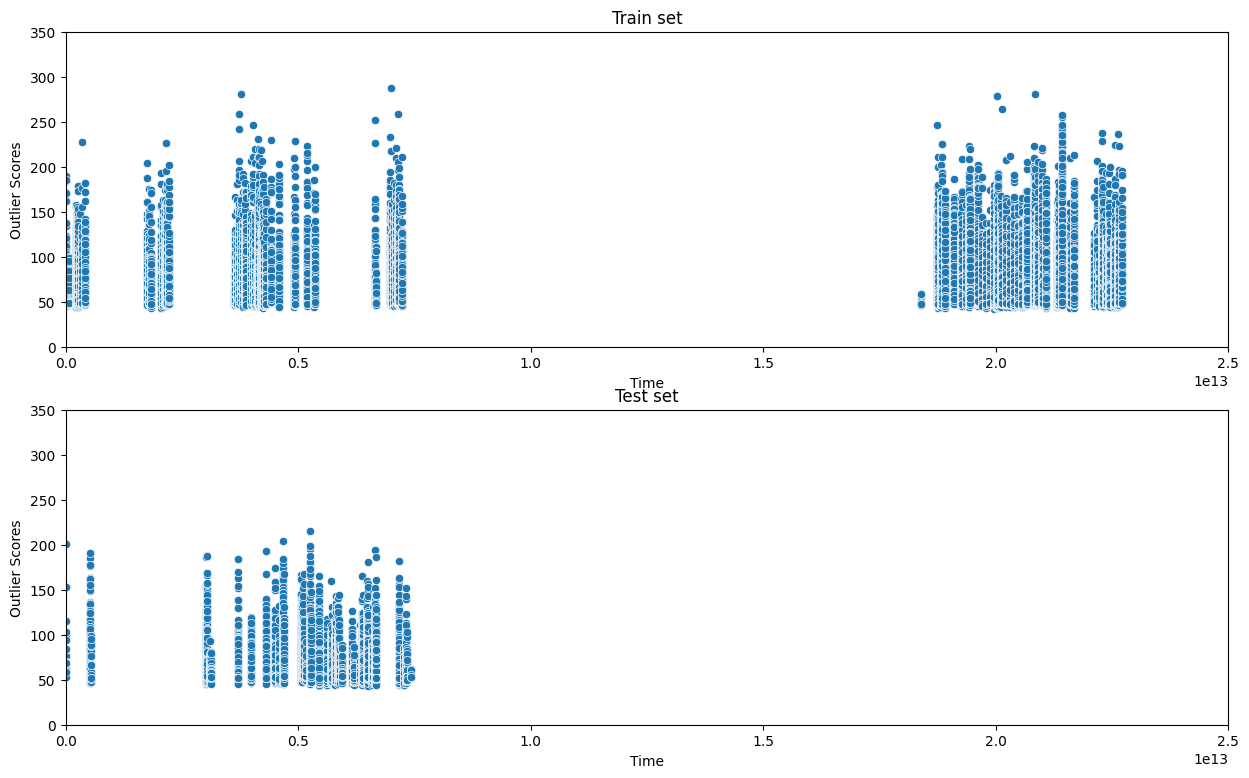

In [310]:
plt.figure(figsize=(15, 9))
train_index = X_train.index - X_train.index[0]
test_index = X_test.index - X_test.index[0]

plt.subplot(2, 1, 1)
sns.scatterplot(x=train_index, y=y_train_scores)
plt.xlim(0, 2.5e13)
plt.ylim(0, 350)
plt.xlabel('Time')
plt.ylabel('Outlier Scores')
plt.title('Train set')

plt.subplot(2, 1, 2)
sns.scatterplot(x=test_index, y=y_test_scores)
plt.xlim(0, 2.5e13)
plt.ylim(0, 350)
plt.xlabel('Time')
plt.ylabel('Outlier Scores')
plt.title('Test set')
plt.show()

# COPOD

In [306]:
from pyod.models.copod import COPOD
clf = COPOD()
clf.fit(X_train)

COPOD(contamination=0.1, n_jobs=1)

In [307]:
# get predictions and outlier scores
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores on the train data

y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # predict raw outlier scores on test
y_test_proba = clf.predict_proba(X_test) # outlier probability

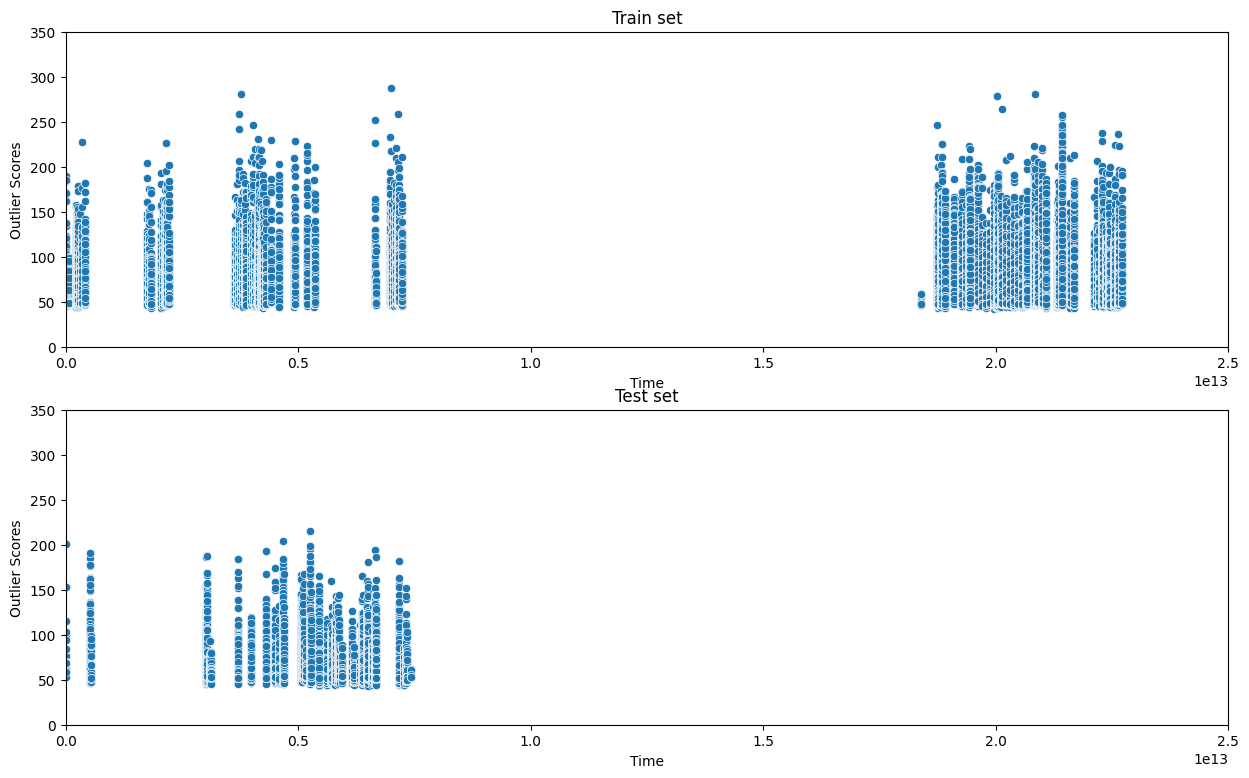

In [309]:
plt.figure(figsize=(15, 9))

plt.subplot(2, 1, 1)
sns.scatterplot(x=train_index, y=y_train_scores)
plt.xlim(0, 2.5e13)
plt.ylim(0, 350)
plt.xlabel('Time')
plt.ylabel('Outlier Scores')
plt.title('Train set')

plt.subplot(2, 1, 2)
sns.scatterplot(x=test_index, y=y_test_scores)
plt.xlim(0, 2.5e13)
plt.ylim(0, 350)
plt.xlabel('Time')
plt.ylabel('Outlier Scores')
plt.title('Test set')
plt.show()

# CAPACITY PREDICTION USING FORECASTED FEATURES

In [4]:
data_for = produce_data_for()

In [6]:
def CapacityOverTime(sample, N_window):
    SoC = sample["SoC"].values
    Curr = sample["Curr"].values
    #Volt = sample["Volt"].values
    timestamp = sample.index.values/1000000
    Temp = sample["Temp"].values
    deltaTime = timestamp[1:]-timestamp[0:-1]
    avgCurr = (Curr[0:-1] + Curr[1:])/2
    deltaCharge = deltaTime * avgCurr
    accuCharge = np.cumsum(deltaCharge)
    accuCharge = np.insert(accuCharge, 0, 0)
    rows = []
    #for i in range(N_window, len(sample), int(N_window/100)):
    for i in range(N_window, len(sample), int(N_window/10)):
        DiffSoC = SoC[i] - SoC[i-N_window]
        DiffCharge = accuCharge[i] - accuCharge[i-N_window]
        max_curr = Curr[i-N_window:i+1].max()
        min_curr = Curr[i-N_window:i+1].min()
        mean_curr = Curr[i-N_window:i+1].mean()
        std_curr = Curr[i-N_window:i+1].std()
        row = {"timestamp": timestamp[i], "CapacityWindow": -DiffCharge/DiffSoC, "Temp": Temp[i], "DiffCharge": DiffCharge, "DiffSoC": DiffSoC,
               "CurrMax": max_curr, "CurrMin": min_curr, "CurrMean": mean_curr, "CurrStd": std_curr}
        rows.append(row)
    df_diffcapacity = pd.DataFrame(rows)
    return df_diffcapacity, accuCharge, SoC

In [7]:
df_Capacity = []
for i in range(len(data_for)):
    if int(len(data_for[i])/10)<10:
        continue
    df_diffcapacity, accuCharge, SoC = CapacityOverTime(data_for[i], N_window =int(len(data_for[i])/10))
    df_Capacity.append(df_diffcapacity)

/tmp/ipykernel_112798/566062891.py:21: RuntimeWarning: divide by zero encountered in scalar divide
  row = {"timestamp": timestamp[i], "CapacityWindow": -DiffCharge/DiffSoC, "Temp": Temp[i], "DiffCharge": DiffCharge, "DiffSoC": DiffSoC,
/tmp/ipykernel_112798/566062891.py:21: RuntimeWarning: invalid value encountered in scalar divide
  row = {"timestamp": timestamp[i], "CapacityWindow": -DiffCharge/DiffSoC, "Temp": Temp[i], "DiffCharge": DiffCharge, "DiffSoC": DiffSoC,


In [8]:
df_forecast = pd.concat([df for df in df_Capacity])
df_forecast.set_index("timestamp", inplace=True)
df_forecast_sorted = df_forecast.sort_index()
df_forecast_sorted = df_forecast_sorted[~df_forecast_sorted.isin([np.inf, -np.inf]).any(axis=1)]
df_forecast_sorted = df_forecast_sorted.dropna()

In [9]:
df_forecast_sorted.columns

Index(['CapacityWindow', 'Temp', 'DiffCharge', 'DiffSoC', 'CurrMax', 'CurrMin',
       'CurrMean', 'CurrStd'],
      dtype='object')

In [158]:
columns = ['Temp', 'CurrMax', 'CurrMin', 'CurrMean', 'CurrStd', 'DiffCharge', 'DiffSoC']
X = df_forecast_sorted[columns]
y = df_forecast_sorted['CapacityWindow']

In [159]:
split_index_train = int(0.6 * X.shape[0])
split_index_val = int(0.8 * X.shape[0])

X_train  = X.iloc[:split_index_train]
X_val = X.iloc[split_index_train:split_index_val]
X_test = X.iloc[split_index_val:]

y_train = y.iloc[:split_index_train]
y_val = y.iloc[split_index_train:split_index_val]
y_test = y.iloc[split_index_val:]

print("Training set shape:", X_train.shape)
print("Training set shape:", X_val.shape)
print("Testing set shape:", X_test.shape)
print("Training output shape:", y_train.shape)
print("Training output shape:", y_val.shape)
print("Testing output shape:", y_test.shape)

Training set shape: (13038, 7)
Training set shape: (4346, 7)
Testing set shape: (4347, 7)
Training output shape: (13038,)
Training output shape: (4346,)
Testing output shape: (4347,)


In [735]:
mean_temp = np.mean(X_train['Temp'])
std_temp = np.std(X_train['Temp'])

mean_currmax = np.mean(X_train['CurrMax'])
std_currmax = np.std(X_train['CurrMax'])

mean_currmin = np.mean(X_train['CurrMin'])
std_currmin = np.std(X_train['CurrMin'])

mean_currmean = np.mean(X_train['CurrMean'])
std_currmean = np.std(X_train['CurrMean'])

mean_currstd = np.mean(X_train['CurrStd'])
std_currstd = np.std(X_train['CurrStd'])

In [160]:
scaler = MinMaxScaler()
X_train_ = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val_ = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test_ = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [161]:
linear_reg = LinearRegression()
linear_reg.fit(X_train_, y_train)
linear_reg_predictions = linear_reg.predict(X_val_)
linear_reg_rmse = np.sqrt(mean_squared_error(y_val, linear_reg_predictions))

lasso_reg = Lasso()
lasso_reg.fit(X_train_, y_train)
lasso_reg_predictions = lasso_reg.predict(X_val_)
lasso_reg_rmse = np.sqrt(mean_squared_error(y_val, linear_reg_predictions))

ridge_reg = Ridge()
ridge_reg.fit(X_train_, y_train)
ridge_reg_predictions = ridge_reg.predict(X_val_)
ridge_reg_rmse = np.sqrt(mean_squared_error(y_val, linear_reg_predictions))

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train_, y_train)
tree_reg_predictions = tree_reg.predict(X_val_)
tree_reg_rmse = np.sqrt(mean_squared_error(y_val, tree_reg_predictions))

rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train_, y_train)
rf_reg_predictions = rf_reg.predict(X_val_)
rf_reg_rmse = np.sqrt(mean_squared_error(y_val, rf_reg_predictions))

gboost_reg = GradientBoostingRegressor(n_estimators=100, learning_rate=0.01, random_state=42)
gboost_reg.fit(X_train_, y_train)
gboost_reg_predictions = gboost_reg.predict(X_val_)
gboost_reg_rmse = np.sqrt(mean_squared_error(y_val, gboost_reg_predictions))

xgboost_reg = xgb.XGBRegressor(n_estimators=100, learning_rate=0.01, random_state=42)
xgboost_reg.fit(X_train_, y_train)
xgboost_reg_predictions = xgboost_reg.predict(X_val_)
xgboost_reg_rmse = np.sqrt(mean_squared_error(y_val, xgboost_reg_predictions))

print("Linear Regression RMSE:", linear_reg_rmse)
print("Lasso Regression RMSE:", lasso_reg_rmse)
print("Ridge Regression RMSE:", ridge_reg_rmse)
print("Decision Tree Regression RMSE:", tree_reg_rmse)
print("Random Forest Regression RMSE:", rf_reg_rmse)
print("Gradient Boosting Regression RMSE:", gboost_reg_rmse)
print("XGBoost Regression RMSE:", xgboost_reg_rmse)

Linear Regression RMSE: 2325.692100967461
Lasso Regression RMSE: 2608.321223743117
Ridge Regression RMSE: 2869.4744364409376
Decision Tree Regression RMSE: 1172.5624065665122
Random Forest Regression RMSE: 1307.5334894962496
Gradient Boosting Regression RMSE: 2422.8812638165323
XGBoost Regression RMSE: 2318.8648876630314


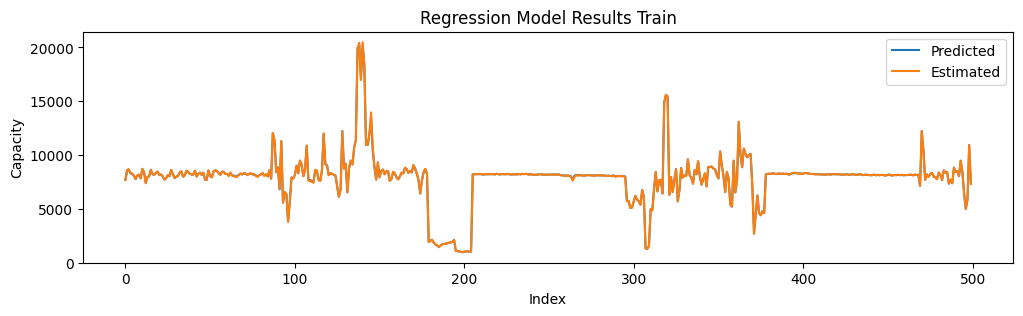

In [163]:
train_predictions = rf_reg.predict(X_train_)
fig = plt.figure(figsize=(12, 3))
plt.plot(train_predictions[:500])
plt.plot(y_train.values[:500])
plt.xlabel('Index')
plt.ylabel('Capacity')
plt.title('Regression Model Results Train')
plt.legend(['Predicted', 'Estimated'])
plt.show()

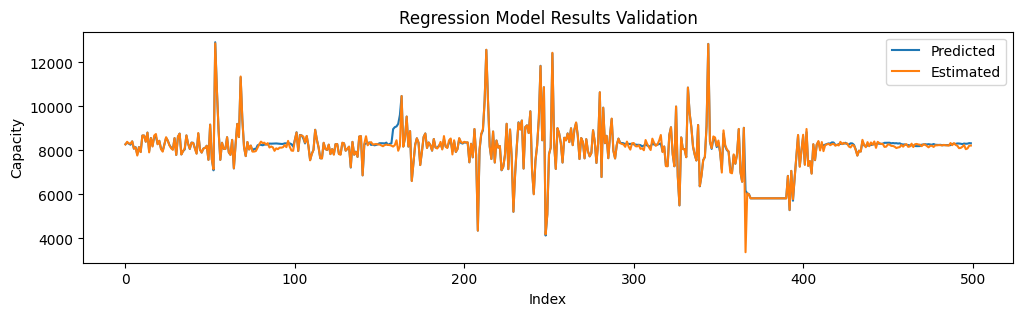

In [164]:
val_predictions = rf_reg.predict(X_val_)
fig = plt.figure(figsize=(12, 3))
plt.plot(val_predictions[:500])
plt.plot(y_val.values[:500])
plt.xlabel('Index')
plt.ylabel('Capacity')
plt.title('Regression Model Results Validation')
plt.legend(['Predicted', 'Estimated'])
plt.show()

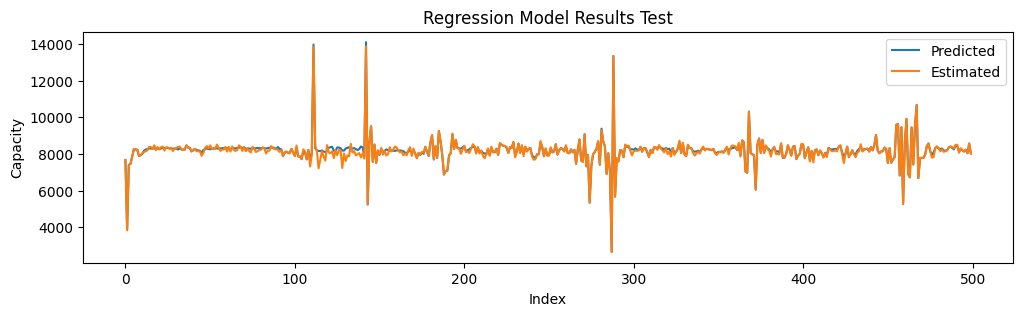

In [165]:
test_predictions = rf_reg.predict(X_test_)
fig = plt.figure(figsize=(12, 3))
plt.plot(test_predictions[:500])
plt.plot(y_test.values[:500])
plt.xlabel('Index')
plt.ylabel('Capacity')
plt.title('Regression Model Results Test')
plt.legend(['Predicted', 'Estimated'])
plt.show()

# MONTE CARLO

In [438]:
def predic_rul(m0, d0, n, lmax):
    step = int((int(2*(df_forecast_sorted.index.max())) - int(df_forecast_sorted.index.min()))/(lmax-1))
    mean_temp, std_temp = norm.fit(d0['Temp'])
    mean_cmax, std_cmax = norm.fit(d0['CurrMax'])
    mean_cmin, std_cmin = norm.fit(d0['CurrMin'])
    mean_cmean, std_cmean = norm.fit(d0['CurrMean'])
    mean_cstd, std_cstd = norm.fit(d0['CurrStd'])
    #OUT = np.zeros(n)
    for i in range(n):
        simdf = pd.DataFrame({'timestamp': np.arange(int(d0.index.min()), int(2*(d0.index.max())), step)})
        simdf['Temp'] = np.random.normal(mean_temp, std_temp, lmax)
        simdf['CurrMax'] = np.random.normal(mean_cmax, std_cmax, lmax)
        simdf['CurrMin'] = np.random.normal(mean_cmin, std_cmin, lmax)
        simdf['CurrMean'] = np.random.normal(mean_cmean, std_cmean, lmax)
        simdf['CurrStd'] = np.random.normal(mean_cstd, std_cstd, lmax)
        predf = simdf[['Temp', 'CurrMax', 'CurrMin', 'CurrMean', 'CurrStd']]
        OUT = m0.predict(predf)
        #OUT[i] = np.min(np.where(m0.predict(predf) <= 0.8))

    return OUT, simdf

In [ ]:
pred_capacity, sim_X = predic_rul(linear_reg, X, 1, 500)

# FORECASTING

In [166]:
def df_to_X_y(df, window_size):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = [r for r in df_as_np[i+window_size]]
    y.append(label)
  return np.array(X), np.array(y)

In [167]:
window_size = 5
X_train_forecast, y_train_forecast = df_to_X_y(X_train_, window_size)
X_val_forecast, y_val_forecast = df_to_X_y(X_val_, window_size)
X_test_forecast, y_test_forecast = df_to_X_y(X_test_, window_size)

In [168]:
X_train_forecast.shape, y_train_forecast.shape, X_val_forecast.shape, y_val_forecast.shape, X_test_forecast.shape, y_test_forecast.shape

((13033, 5, 7), (13033, 7), (4341, 5, 7), (4341, 7), (4342, 5, 7), (4342, 7))

In [177]:
def plot_predictions(m, X_data, y_data, start=0, end=500):
    predictions = m.predict(X_data)
    preds_1, preds_2, preds_3, preds_4, preds_5, preds_6, preds_7 = predictions[:, 0], predictions[:, 1], predictions[:, 2], predictions[:, 3], predictions[:, 4], predictions[:, 5], predictions[:, 6]
    actuals_1, actuals_2, actuals_3, actuals_4, actuals_5, actuals_6, actuals_7 = y_data[:, 0], y_data[:, 1], y_data[:, 2], y_data[:, 3], y_data[:, 4], y_data[:,5], y_data[:,6]
  
    df = pd.DataFrame(data={'Temp': preds_1,
                            'Temp Actuals': actuals_1,
                            'CurrMax': preds_2,
                            'CurrMax Actuals': actuals_2,
                            'CurrMin': preds_3,
                            'CurrMin Actuals': actuals_3,
                            'CurrMean': preds_4,
                            'CurrMean Actuals': actuals_4,
                            'CurrStd': preds_5,
                            'CurrStd Actuals': actuals_5,
                            'DiffCharge': preds_6,
                            'DiffCharge Actuals': actuals_6,
                            'DiffSoC': preds_7,
                            'DiffSoC Actuals': actuals_7})

    plt.figure(figsize=(10, 8))

    plt.subplot(4, 2, 1)
    plt.plot(df['Temp'][start:end])
    plt.plot(df['Temp Actuals'][start:end])
    plt.title('Temperature')

    plt.subplot(4, 2, 2)
    plt.plot(df['CurrMax'][start:end])
    plt.plot(df['CurrMax Actuals'][start:end])
    plt.title('CurrMax')

    plt.subplot(4, 2, 3)
    plt.plot(df['CurrMin'][start:end])
    plt.plot(df['CurrMin Actuals'][start:end])
    plt.title('CurrMin')

    plt.subplot(4, 2, 4)
    plt.plot(df['CurrMean'][start:end])
    plt.plot(df['CurrMean Actuals'][start:end])
    plt.title('CurrMean')

    plt.subplot(4, 2, 5)
    plt.plot(df['CurrStd'][start:end])
    plt.plot(df['CurrStd Actuals'][start:end])
    plt.title('CurrStd')

    plt.subplot(4, 2, 6)
    plt.plot(df['DiffCharge'][start:end])
    plt.plot(df['DiffCharge Actuals'][start:end])
    plt.title('DiffCharge')

    plt.subplot(4, 2, 7)
    plt.plot(df['DiffSoC'][start:end])
    plt.plot(df['DiffSoC Actuals'][start:end])
    plt.title('DiffSoC')

    plt.tight_layout()  
    plt.show()  
    
    return df

# LSTM

In [171]:
n_features = X_train_forecast.shape[2]

In [172]:
n_features

7

In [113]:
model_lstm = Sequential()
model_lstm.add(InputLayer((window_size, n_features)))
model_lstm.add(LSTM(64))
model_lstm.add(Dense(8, 'relu'))
model_lstm.add(Dense(n_features, 'linear'))

model_lstm.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                18432     
                                                                 
 dense_22 (Dense)            (None, 8)                 520       
                                                                 
 dense_23 (Dense)            (None, 7)                 63        
                                                                 
Total params: 19015 (74.28 KB)
Trainable params: 19015 (74.28 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [115]:
cp_lstm = ModelCheckpoint('model_lstm/', save_best_only = True)
model_lstm.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics = [RootMeanSquaredError()])
model_lstm.fit(X_train_forecast, y_train_forecast, validation_data=(X_val_forecast, y_val_forecast), epochs=30, callbacks=[cp_lstm])

Epoch 1/30
404/408 [============================>.] - ETA: 0s - loss: 0.0027 - root_mean_squared_error: 0.0518INFO:tensorflow:Assets written to: model_lstm/assets


INFO:tensorflow:Assets written to: model_lstm/assets


408/408 [==============================] - 11s 21ms/step - loss: 0.0027 - root_mean_squared_error: 0.0517 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0392
Epoch 2/30
408/408 [==============================] - 4s 10ms/step - loss: 0.0026 - root_mean_squared_error: 0.0514 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0393
Epoch 3/30
404/408 [============================>.] - ETA: 0s - loss: 0.0026 - root_mean_squared_error: 0.0511INFO:tensorflow:Assets written to: model_lstm/assets


INFO:tensorflow:Assets written to: model_lstm/assets


408/408 [==============================] - 8s 19ms/step - loss: 0.0026 - root_mean_squared_error: 0.0511 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0389
Epoch 4/30
404/408 [============================>.] - ETA: 0s - loss: 0.0026 - root_mean_squared_error: 0.0508INFO:tensorflow:Assets written to: model_lstm/assets


INFO:tensorflow:Assets written to: model_lstm/assets


408/408 [==============================] - 9s 22ms/step - loss: 0.0026 - root_mean_squared_error: 0.0507 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0387
Epoch 5/30
408/408 [==============================] - 4s 10ms/step - loss: 0.0025 - root_mean_squared_error: 0.0504 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0389
Epoch 6/30
403/408 [============================>.] - ETA: 0s - loss: 0.0025 - root_mean_squared_error: 0.0503INFO:tensorflow:Assets written to: model_lstm/assets


INFO:tensorflow:Assets written to: model_lstm/assets


408/408 [==============================] - 8s 20ms/step - loss: 0.0025 - root_mean_squared_error: 0.0503 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0378
Epoch 7/30
404/408 [============================>.] - ETA: 0s - loss: 0.0025 - root_mean_squared_error: 0.0499INFO:tensorflow:Assets written to: model_lstm/assets


INFO:tensorflow:Assets written to: model_lstm/assets


408/408 [==============================] - 8s 19ms/step - loss: 0.0025 - root_mean_squared_error: 0.0500 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0373
Epoch 8/30
408/408 [==============================] - 4s 10ms/step - loss: 0.0025 - root_mean_squared_error: 0.0498 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0374
Epoch 9/30
406/408 [============================>.] - ETA: 0s - loss: 0.0025 - root_mean_squared_error: 0.0496INFO:tensorflow:Assets written to: model_lstm/assets


INFO:tensorflow:Assets written to: model_lstm/assets


408/408 [==============================] - 8s 19ms/step - loss: 0.0025 - root_mean_squared_error: 0.0496 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0373
Epoch 10/30
406/408 [============================>.] - ETA: 0s - loss: 0.0024 - root_mean_squared_error: 0.0494INFO:tensorflow:Assets written to: model_lstm/assets


INFO:tensorflow:Assets written to: model_lstm/assets


408/408 [==============================] - 8s 19ms/step - loss: 0.0024 - root_mean_squared_error: 0.0494 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0368
Epoch 11/30
405/408 [============================>.] - ETA: 0s - loss: 0.0024 - root_mean_squared_error: 0.0492INFO:tensorflow:Assets written to: model_lstm/assets


INFO:tensorflow:Assets written to: model_lstm/assets


408/408 [==============================] - 8s 19ms/step - loss: 0.0024 - root_mean_squared_error: 0.0492 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0365
Epoch 12/30
407/408 [============================>.] - ETA: 0s - loss: 0.0024 - root_mean_squared_error: 0.0490INFO:tensorflow:Assets written to: model_lstm/assets


INFO:tensorflow:Assets written to: model_lstm/assets


408/408 [==============================] - 9s 22ms/step - loss: 0.0024 - root_mean_squared_error: 0.0490 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0362
Epoch 13/30
408/408 [==============================] - 4s 10ms/step - loss: 0.0024 - root_mean_squared_error: 0.0489 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0369
Epoch 14/30
405/408 [============================>.] - ETA: 0s - loss: 0.0024 - root_mean_squared_error: 0.0488INFO:tensorflow:Assets written to: model_lstm/assets


INFO:tensorflow:Assets written to: model_lstm/assets


408/408 [==============================] - 8s 19ms/step - loss: 0.0024 - root_mean_squared_error: 0.0488 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0359
Epoch 15/30
407/408 [============================>.] - ETA: 0s - loss: 0.0024 - root_mean_squared_error: 0.0485INFO:tensorflow:Assets written to: model_lstm/assets


INFO:tensorflow:Assets written to: model_lstm/assets


408/408 [==============================] - 8s 19ms/step - loss: 0.0024 - root_mean_squared_error: 0.0486 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0358
Epoch 16/30
405/408 [============================>.] - ETA: 0s - loss: 0.0024 - root_mean_squared_error: 0.0485INFO:tensorflow:Assets written to: model_lstm/assets


INFO:tensorflow:Assets written to: model_lstm/assets


408/408 [==============================] - 8s 19ms/step - loss: 0.0024 - root_mean_squared_error: 0.0485 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0357
Epoch 17/30
404/408 [============================>.] - ETA: 0s - loss: 0.0023 - root_mean_squared_error: 0.0484INFO:tensorflow:Assets written to: model_lstm/assets


INFO:tensorflow:Assets written to: model_lstm/assets


408/408 [==============================] - 8s 19ms/step - loss: 0.0023 - root_mean_squared_error: 0.0484 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0354
Epoch 18/30
408/408 [==============================] - 4s 10ms/step - loss: 0.0023 - root_mean_squared_error: 0.0482 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0356
Epoch 19/30
408/408 [==============================] - 4s 10ms/step - loss: 0.0023 - root_mean_squared_error: 0.0481 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0356
Epoch 20/30
403/408 [============================>.] - ETA: 0s - loss: 0.0023 - root_mean_squared_error: 0.0480INFO:tensorflow:Assets written to: model_lstm/assets


INFO:tensorflow:Assets written to: model_lstm/assets


408/408 [==============================] - 8s 19ms/step - loss: 0.0023 - root_mean_squared_error: 0.0481 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0354
Epoch 21/30
404/408 [============================>.] - ETA: 0s - loss: 0.0023 - root_mean_squared_error: 0.0480INFO:tensorflow:Assets written to: model_lstm/assets


INFO:tensorflow:Assets written to: model_lstm/assets


408/408 [==============================] - 9s 22ms/step - loss: 0.0023 - root_mean_squared_error: 0.0480 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0351
Epoch 22/30
408/408 [==============================] - 4s 10ms/step - loss: 0.0023 - root_mean_squared_error: 0.0479 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0354
Epoch 23/30
408/408 [==============================] - 4s 10ms/step - loss: 0.0023 - root_mean_squared_error: 0.0479 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0352
Epoch 24/30
408/408 [==============================] - 4s 10ms/step - loss: 0.0023 - root_mean_squared_error: 0.0477 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0352
Epoch 25/30
403/408 [============================>.] - ETA: 0s - loss: 0.0023 - root_mean_squared_error: 0.0476INFO:tensorflow:Assets written to: model_lstm/assets


INFO:tensorflow:Assets written to: model_lstm/assets


408/408 [==============================] - 8s 19ms/step - loss: 0.0023 - root_mean_squared_error: 0.0477 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0347
Epoch 26/30
407/408 [============================>.] - ETA: 0s - loss: 0.0023 - root_mean_squared_error: 0.0476INFO:tensorflow:Assets written to: model_lstm/assets


INFO:tensorflow:Assets written to: model_lstm/assets


408/408 [==============================] - 8s 19ms/step - loss: 0.0023 - root_mean_squared_error: 0.0476 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0347
Epoch 27/30
403/408 [============================>.] - ETA: 0s - loss: 0.0023 - root_mean_squared_error: 0.0476INFO:tensorflow:Assets written to: model_lstm/assets


INFO:tensorflow:Assets written to: model_lstm/assets


408/408 [==============================] - 8s 19ms/step - loss: 0.0023 - root_mean_squared_error: 0.0476 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0346
Epoch 28/30
408/408 [==============================] - 4s 10ms/step - loss: 0.0023 - root_mean_squared_error: 0.0475 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0353
Epoch 29/30
408/408 [==============================] - 4s 10ms/step - loss: 0.0022 - root_mean_squared_error: 0.0474 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0347
Epoch 30/30
408/408 [==============================] - 4s 10ms/step - loss: 0.0022 - root_mean_squared_error: 0.0473 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0346


# CNN

In [175]:
model_cnn = Sequential()
model_cnn.add(InputLayer((window_size, n_features)))
model_cnn.add(Conv1D(64, kernel_size=2, activation='relu'))
model_cnn.add(Conv1D(32, kernel_size=2, activation='relu'))
model_cnn.add(Flatten())
model_cnn.add(Dense(8, 'relu'))
model_cnn.add(Dense(n_features, 'linear'))
model_cnn.summary()

cp_cnn = ModelCheckpoint('model_cnn/', save_best_only=True)
model_cnn.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_15 (Conv1D)          (None, 4, 64)             960       
                                                                 
 conv1d_16 (Conv1D)          (None, 3, 32)             4128      
                                                                 
 flatten_15 (Flatten)        (None, 96)                0         
                                                                 
 dense_42 (Dense)            (None, 8)                 776       
                                                                 
 dense_43 (Dense)            (None, 7)                 63        
                                                                 
Total params: 5927 (23.15 KB)
Trainable params: 5927 (23.15 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [176]:
model_cnn.fit(X_train_forecast, y_train_forecast, validation_data=(X_val_forecast, y_val_forecast), epochs=30, callbacks=[cp_cnn])

Epoch 1/30
402/408 [============================>.] - ETA: 0s - loss: 0.2356 - root_mean_squared_error: 0.4854INFO:tensorflow:Assets written to: model_cnn/assets


INFO:tensorflow:Assets written to: model_cnn/assets


408/408 [==============================] - 4s 7ms/step - loss: 0.2351 - root_mean_squared_error: 0.4849 - val_loss: 0.2105 - val_root_mean_squared_error: 0.4589
Epoch 2/30
396/408 [============================>.] - ETA: 0s - loss: 0.1625 - root_mean_squared_error: 0.4031INFO:tensorflow:Assets written to: model_cnn/assets


INFO:tensorflow:Assets written to: model_cnn/assets


408/408 [==============================] - 3s 7ms/step - loss: 0.1615 - root_mean_squared_error: 0.4018 - val_loss: 0.1361 - val_root_mean_squared_error: 0.3689
Epoch 3/30
404/408 [============================>.] - ETA: 0s - loss: 0.0915 - root_mean_squared_error: 0.3024INFO:tensorflow:Assets written to: model_cnn/assets


INFO:tensorflow:Assets written to: model_cnn/assets


408/408 [==============================] - 3s 7ms/step - loss: 0.0912 - root_mean_squared_error: 0.3020 - val_loss: 0.0709 - val_root_mean_squared_error: 0.2662
Epoch 4/30
396/408 [============================>.] - ETA: 0s - loss: 0.0369 - root_mean_squared_error: 0.1921INFO:tensorflow:Assets written to: model_cnn/assets


INFO:tensorflow:Assets written to: model_cnn/assets


408/408 [==============================] - 3s 7ms/step - loss: 0.0364 - root_mean_squared_error: 0.1908 - val_loss: 0.0234 - val_root_mean_squared_error: 0.1529
Epoch 5/30
400/408 [============================>.] - ETA: 0s - loss: 0.0141 - root_mean_squared_error: 0.1186INFO:tensorflow:Assets written to: model_cnn/assets


INFO:tensorflow:Assets written to: model_cnn/assets


408/408 [==============================] - 3s 7ms/step - loss: 0.0140 - root_mean_squared_error: 0.1185 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1074
Epoch 6/30
403/408 [============================>.] - ETA: 0s - loss: 0.0113 - root_mean_squared_error: 0.1061INFO:tensorflow:Assets written to: model_cnn/assets


INFO:tensorflow:Assets written to: model_cnn/assets


408/408 [==============================] - 3s 7ms/step - loss: 0.0112 - root_mean_squared_error: 0.1060 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0970
Epoch 7/30
400/408 [============================>.] - ETA: 0s - loss: 0.0108 - root_mean_squared_error: 0.1039INFO:tensorflow:Assets written to: model_cnn/assets


INFO:tensorflow:Assets written to: model_cnn/assets


408/408 [==============================] - 4s 9ms/step - loss: 0.0108 - root_mean_squared_error: 0.1039 - val_loss: 0.0089 - val_root_mean_squared_error: 0.0943
Epoch 8/30
405/408 [============================>.] - ETA: 0s - loss: 0.0105 - root_mean_squared_error: 0.1022INFO:tensorflow:Assets written to: model_cnn/assets


INFO:tensorflow:Assets written to: model_cnn/assets


408/408 [==============================] - 3s 7ms/step - loss: 0.0105 - root_mean_squared_error: 0.1022 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0927
Epoch 9/30
403/408 [============================>.] - ETA: 0s - loss: 0.0101 - root_mean_squared_error: 0.1004INFO:tensorflow:Assets written to: model_cnn/assets


INFO:tensorflow:Assets written to: model_cnn/assets


408/408 [==============================] - 3s 7ms/step - loss: 0.0101 - root_mean_squared_error: 0.1004 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0912
Epoch 10/30
401/408 [============================>.] - ETA: 0s - loss: 0.0096 - root_mean_squared_error: 0.0981INFO:tensorflow:Assets written to: model_cnn/assets


INFO:tensorflow:Assets written to: model_cnn/assets


408/408 [==============================] - 3s 7ms/step - loss: 0.0096 - root_mean_squared_error: 0.0981 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0893
Epoch 11/30
403/408 [============================>.] - ETA: 0s - loss: 0.0091 - root_mean_squared_error: 0.0955INFO:tensorflow:Assets written to: model_cnn/assets


INFO:tensorflow:Assets written to: model_cnn/assets


408/408 [==============================] - 3s 7ms/step - loss: 0.0091 - root_mean_squared_error: 0.0955 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0856
Epoch 12/30
406/408 [============================>.] - ETA: 0s - loss: 0.0085 - root_mean_squared_error: 0.0923INFO:tensorflow:Assets written to: model_cnn/assets


INFO:tensorflow:Assets written to: model_cnn/assets


408/408 [==============================] - 3s 7ms/step - loss: 0.0085 - root_mean_squared_error: 0.0923 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0826
Epoch 13/30
406/408 [============================>.] - ETA: 0s - loss: 0.0078 - root_mean_squared_error: 0.0885INFO:tensorflow:Assets written to: model_cnn/assets


INFO:tensorflow:Assets written to: model_cnn/assets


408/408 [==============================] - 3s 7ms/step - loss: 0.0078 - root_mean_squared_error: 0.0885 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0785
Epoch 14/30
402/408 [============================>.] - ETA: 0s - loss: 0.0071 - root_mean_squared_error: 0.0842INFO:tensorflow:Assets written to: model_cnn/assets


INFO:tensorflow:Assets written to: model_cnn/assets


408/408 [==============================] - 3s 7ms/step - loss: 0.0071 - root_mean_squared_error: 0.0842 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0745
Epoch 15/30
404/408 [============================>.] - ETA: 0s - loss: 0.0063 - root_mean_squared_error: 0.0796INFO:tensorflow:Assets written to: model_cnn/assets


INFO:tensorflow:Assets written to: model_cnn/assets


408/408 [==============================] - 3s 7ms/step - loss: 0.0063 - root_mean_squared_error: 0.0796 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0695
Epoch 16/30
406/408 [============================>.] - ETA: 0s - loss: 0.0047 - root_mean_squared_error: 0.0685INFO:tensorflow:Assets written to: model_cnn/assets


INFO:tensorflow:Assets written to: model_cnn/assets


408/408 [==============================] - 3s 7ms/step - loss: 0.0047 - root_mean_squared_error: 0.0685 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0560
Epoch 17/30
396/408 [============================>.] - ETA: 0s - loss: 0.0036 - root_mean_squared_error: 0.0596INFO:tensorflow:Assets written to: model_cnn/assets


INFO:tensorflow:Assets written to: model_cnn/assets


408/408 [==============================] - 3s 7ms/step - loss: 0.0035 - root_mean_squared_error: 0.0594 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0440
Epoch 18/30
402/408 [============================>.] - ETA: 0s - loss: 0.0030 - root_mean_squared_error: 0.0550INFO:tensorflow:Assets written to: model_cnn/assets


INFO:tensorflow:Assets written to: model_cnn/assets


408/408 [==============================] - 3s 7ms/step - loss: 0.0030 - root_mean_squared_error: 0.0550 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0402
Epoch 19/30
404/408 [============================>.] - ETA: 0s - loss: 0.0028 - root_mean_squared_error: 0.0533INFO:tensorflow:Assets written to: model_cnn/assets


INFO:tensorflow:Assets written to: model_cnn/assets


408/408 [==============================] - 3s 7ms/step - loss: 0.0028 - root_mean_squared_error: 0.0533 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0381
Epoch 20/30
396/408 [============================>.] - ETA: 0s - loss: 0.0027 - root_mean_squared_error: 0.0523INFO:tensorflow:Assets written to: model_cnn/assets


INFO:tensorflow:Assets written to: model_cnn/assets


408/408 [==============================] - 3s 7ms/step - loss: 0.0027 - root_mean_squared_error: 0.0522 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0372
Epoch 21/30
407/408 [============================>.] - ETA: 0s - loss: 0.0026 - root_mean_squared_error: 0.0515INFO:tensorflow:Assets written to: model_cnn/assets


INFO:tensorflow:Assets written to: model_cnn/assets


408/408 [==============================] - 3s 7ms/step - loss: 0.0026 - root_mean_squared_error: 0.0515 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0368
Epoch 22/30
398/408 [============================>.] - ETA: 0s - loss: 0.0026 - root_mean_squared_error: 0.0509INFO:tensorflow:Assets written to: model_cnn/assets


INFO:tensorflow:Assets written to: model_cnn/assets


408/408 [==============================] - 3s 6ms/step - loss: 0.0026 - root_mean_squared_error: 0.0509 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0365
Epoch 23/30
407/408 [============================>.] - ETA: 0s - loss: 0.0025 - root_mean_squared_error: 0.0504INFO:tensorflow:Assets written to: model_cnn/assets


INFO:tensorflow:Assets written to: model_cnn/assets


408/408 [==============================] - 3s 7ms/step - loss: 0.0025 - root_mean_squared_error: 0.0504 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0361
Epoch 24/30
405/408 [============================>.] - ETA: 0s - loss: 0.0025 - root_mean_squared_error: 0.0500INFO:tensorflow:Assets written to: model_cnn/assets


INFO:tensorflow:Assets written to: model_cnn/assets


408/408 [==============================] - 3s 6ms/step - loss: 0.0025 - root_mean_squared_error: 0.0500 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0359
Epoch 25/30
406/408 [============================>.] - ETA: 0s - loss: 0.0025 - root_mean_squared_error: 0.0496INFO:tensorflow:Assets written to: model_cnn/assets


INFO:tensorflow:Assets written to: model_cnn/assets


408/408 [==============================] - 3s 6ms/step - loss: 0.0025 - root_mean_squared_error: 0.0496 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0353
Epoch 26/30
408/408 [==============================] - 2s 4ms/step - loss: 0.0024 - root_mean_squared_error: 0.0493 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0361
Epoch 27/30
402/408 [============================>.] - ETA: 0s - loss: 0.0024 - root_mean_squared_error: 0.0491INFO:tensorflow:Assets written to: model_cnn/assets


INFO:tensorflow:Assets written to: model_cnn/assets


408/408 [==============================] - 3s 7ms/step - loss: 0.0024 - root_mean_squared_error: 0.0490 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0353
Epoch 28/30
408/408 [==============================] - 2s 5ms/step - loss: 0.0024 - root_mean_squared_error: 0.0488 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0353
Epoch 29/30
405/408 [============================>.] - ETA: 0s - loss: 0.0024 - root_mean_squared_error: 0.0486INFO:tensorflow:Assets written to: model_cnn/assets


INFO:tensorflow:Assets written to: model_cnn/assets


408/408 [==============================] - 3s 7ms/step - loss: 0.0024 - root_mean_squared_error: 0.0486 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0351
Epoch 30/30
408/408 [==============================] - 2s 5ms/step - loss: 0.0023 - root_mean_squared_error: 0.0483 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0354


In [153]:
model_cnn = load_model('model_cnn/')

In [54]:
train_preds_cnn = model_cnn.predict(X_train_forecast)
val_preds_cnn = model_cnn.predict(X_val_forecast)
test_preds_cnn = model_cnn.predict(X_test_forecast)

136/136 [==============================] - 0s 2ms/step


136/136 [==============================] - 0s 2ms/step


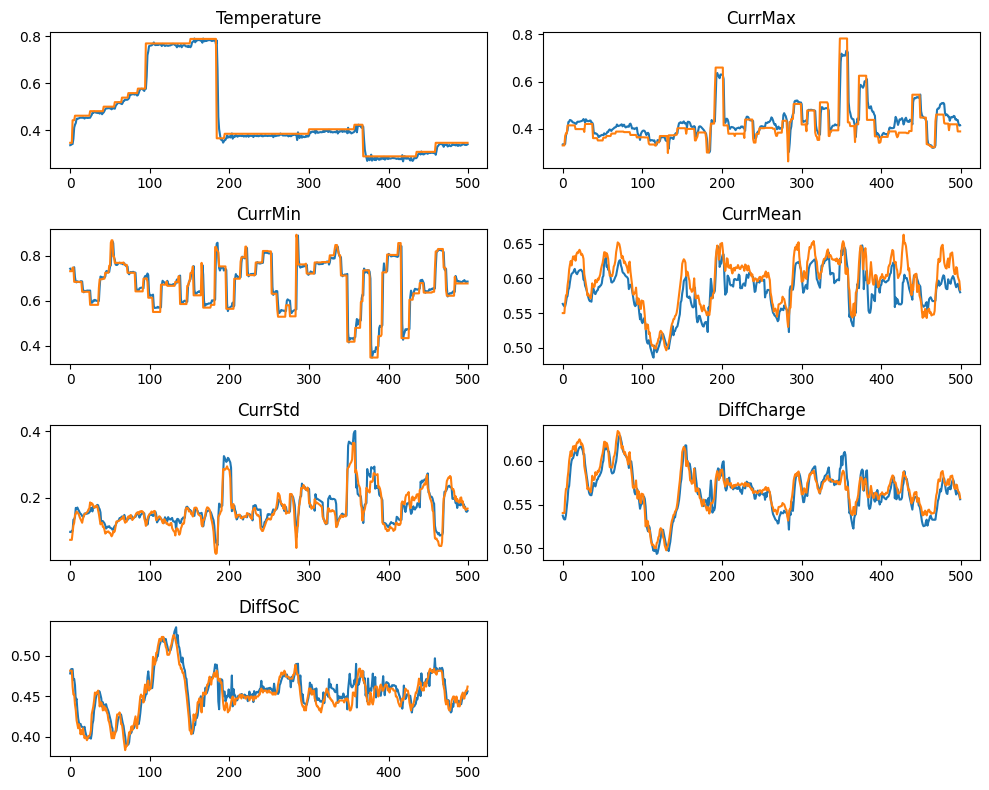

In [178]:
results_test_cnn = plot_predictions(model_cnn, X_test_forecast, y_test_forecast)

In [183]:
results_test_cnn.head(10)

,Temp,Temp Actuals,CurrMax,CurrMax Actuals,CurrMin,CurrMin Actuals,CurrMean,CurrMean Actuals,CurrStd,CurrStd Actuals,DiffCharge,DiffCharge Actuals,DiffSoC,DiffSoC Actuals
0,0.336059,0.346154,0.333747,0.329835,0.743287,0.732394,0.563191,0.549946,0.097626,0.073828,0.537399,0.540398,0.478137,0.481572
1,0.337461,0.346154,0.332981,0.329835,0.739743,0.732394,0.561052,0.549919,0.097162,0.073840,0.534368,0.540387,0.483255,0.481572
2,0.340835,0.346154,0.335923,0.329835,0.736934,0.732394,0.559694,0.549882,0.100725,0.073856,0.533052,0.540370,0.483647,0.481572
3,0.340834,0.442308,0.335950,0.369565,0.736886,0.748239,0.559770,0.564840,0.100684,0.096026,0.533139,0.558417,0.483617,0.461916
4,0.362818,0.442308,0.372176,0.380810,0.744202,0.748239,0.564989,0.575480,0.134146,0.117140,0.538067,0.567717,0.470183,0.452088
5,0.410820,0.442308,0.382404,0.380810,0.750055,0.684859,0.572433,0.576149,0.135657,0.124697,0.546701,0.568209,0.471333,0.452088
6,0.423096,0.461538,0.393921,0.414543,0.705187,0.684859,0.574457,0.589923,0.141945,0.148728,0.555361,0.580127,0.463660,0.439803
7,0.430523,0.461538,0.428497,0.414543,0.684248,0.684859,0.583488,0.598361,0.169573,0.152236,0.568083,0.587442,0.444610,0.432432
8,0.448418,0.461538,0.430419,0.414543,0.682745,0.684859,0.585982,0.612467,0.167754,0.158582,0.571167,0.599635,0.446860,0.420147
9,0.449139,0.461538,0.437520,0.414543,0.687489,0.684859,0.594543,0.619725,0.170755,0.155721,0.582367,0.605949,0.432881,0.415233
